In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
import Intensity_Examiner as IE
import importlib

plt.rcParams["font.family"] = "Times New Roman"



importlib.reload(IE)

<module 'Intensity_Examiner' from 'C:\\Users\\User\\PycharmProjects\\Advanced-Lab-Code\\Intensity_Runs_293K\\Intensity_Examiner.py'>

In [5]:
file = "293K_SectionA.xlsx"
sheets = ["Peak_Spectra"]
cols = [["PS_0", "PS_1", "PS_2", "PS_3", "PS_4", "PS_5", "PS_6", "PS_7", "PS_8", "PS_9"]]
start_index = [9795]


Processing sheet: Peak_Spectra


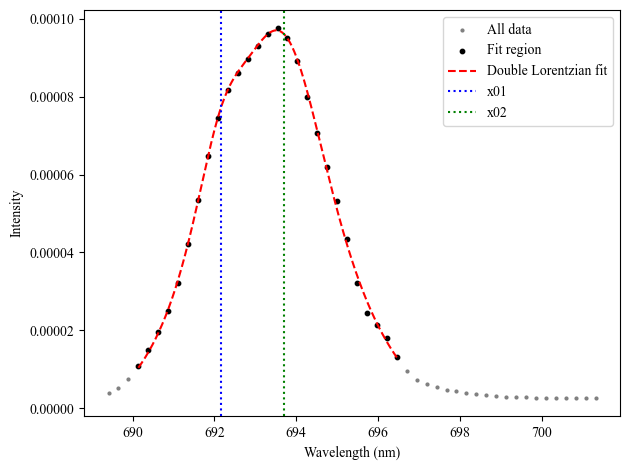

 ----- Results -----
x01: 692.1591919444073
x02: 693.7095098918614
----- ----- -----


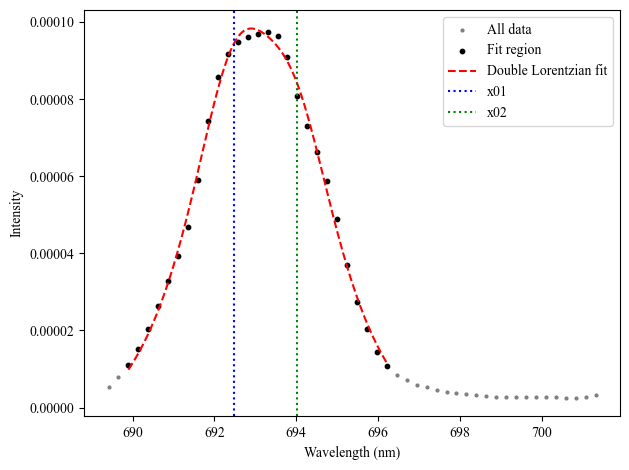

 ----- Results -----
x01: 692.4790613443087
x02: 694.0089438832995
----- ----- -----


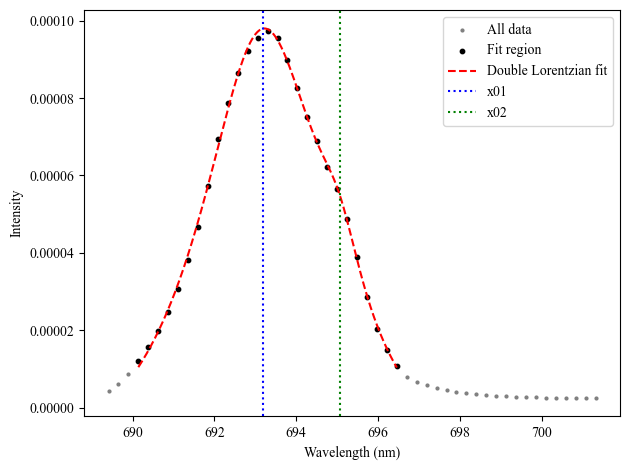

 ----- Results -----
x01: 693.1869800202892
x02: 695.0579551461633
----- ----- -----


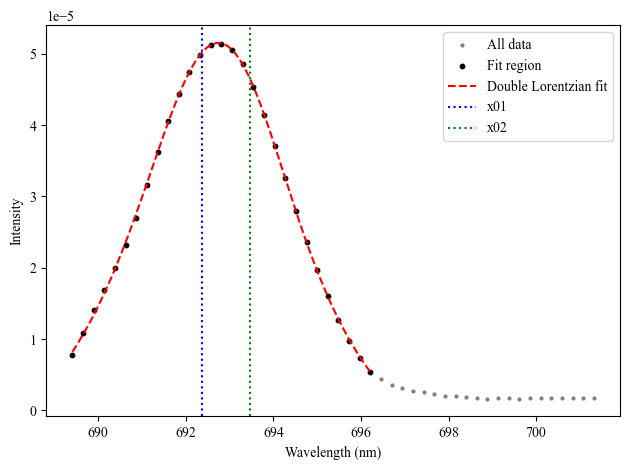

 ----- Results -----
x01: 692.3662666047213
x02: 693.4594920883585
----- ----- -----


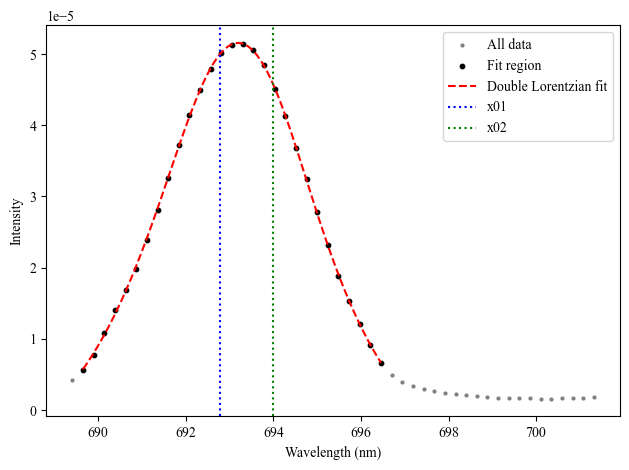

 ----- Results -----
x01: 692.7817044757788
x02: 693.9879481361447
----- ----- -----


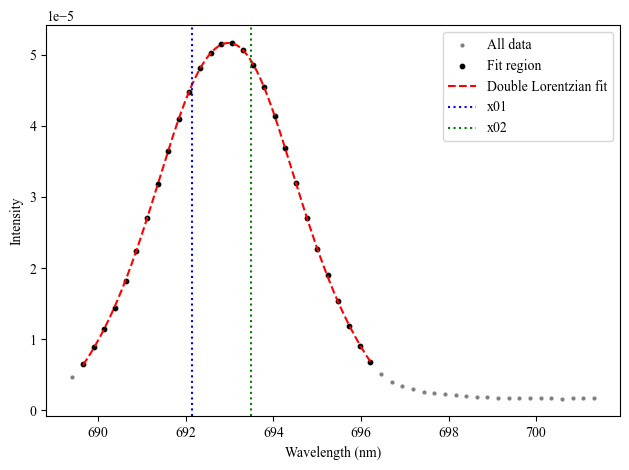

 ----- Results -----
x01: 692.1301000615684
x02: 693.490841605886
----- ----- -----


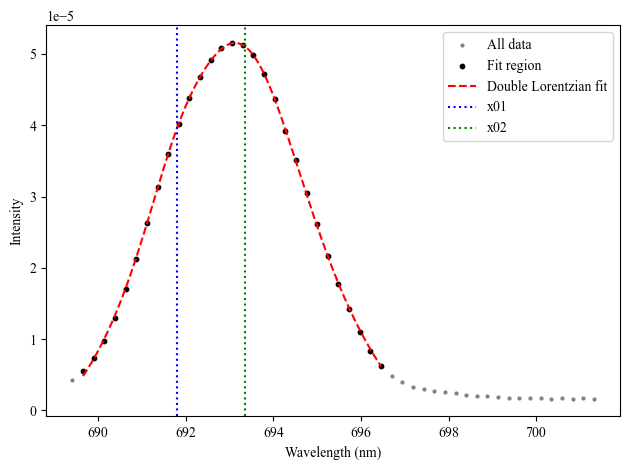

 ----- Results -----
x01: 691.7885473667477
x02: 693.3571493812148
----- ----- -----


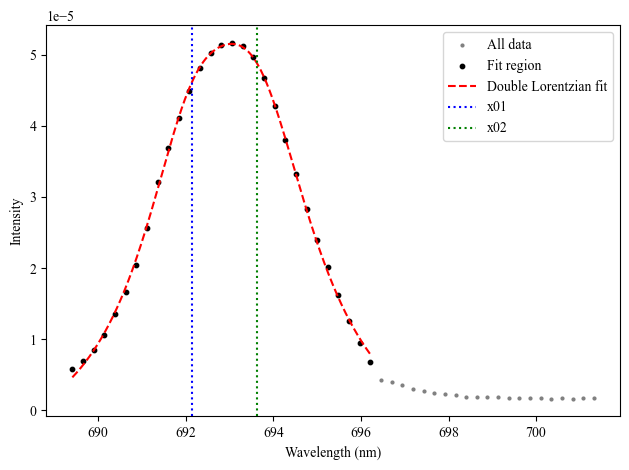

 ----- Results -----
x01: 692.1318362569536
x02: 693.6241216594709
----- ----- -----


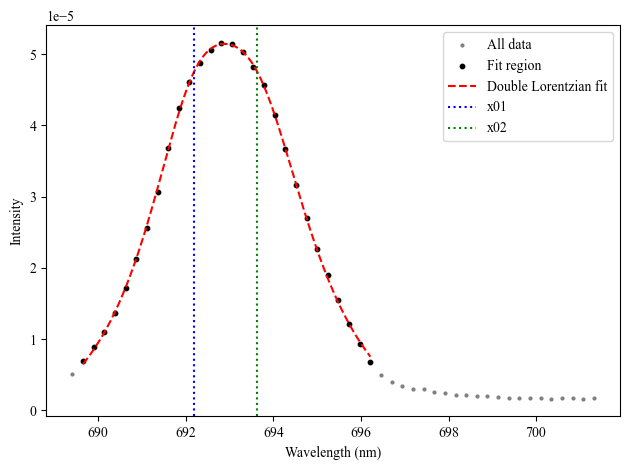

 ----- Results -----
x01: 692.180004167821
x02: 693.622186053725
----- ----- -----


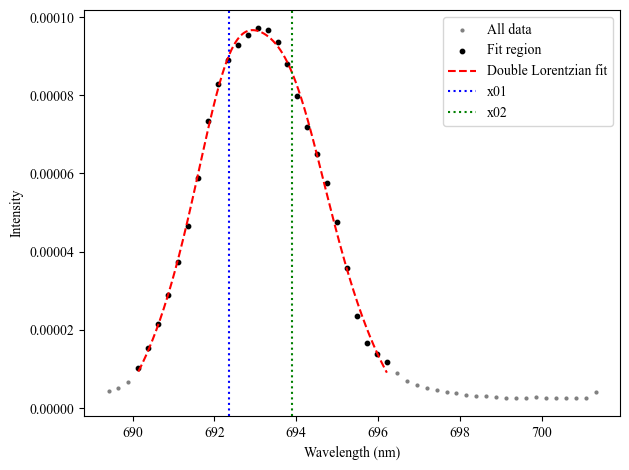

 ----- Results -----
x01: 692.3640041685245
x02: 693.8867753939155
----- ----- -----

Mean x01: 692.3568 ± 0.1175
Mean x02: 693.8205 ± 0.1464
----- ------ -----
x01 Theoretical: 692.9
x02 Theoretical: 694.3


In [6]:
results = IE.double_lorentzian_intensity_extractor(filename= file,
                      sheet_name = sheets,
                      column_name = cols,
                      start_index = start_index,
                        amplitude_frac=0.1)

In [7]:
df = pd.read_excel(file, sheet_name=sheets[0])

indexes = np.arange(0,len(df['PS_0']),1)
wavelengths = IE.wavelength_extraction(indexes, start_index)

In [8]:
dx = np.abs(wavelengths[1]-wavelengths[0])

area_0 = np.sum(dx*df[cols[0][0]])

normalised_spectra = []

for i in range(len(cols[0]) - 1):
    spectrum = df[cols[0][i+1]]
    norm_spec = (spectrum / np.sum(spectrum * dx)) * area_0
    normalised_spectra.append(norm_spec.to_numpy())

y_matrix = np.column_stack(normalised_spectra)
intensity_data = np.mean(y_matrix, axis=1)
intensity_errors = np.std(y_matrix, axis=1, ddof=1) / np.sqrt(8)


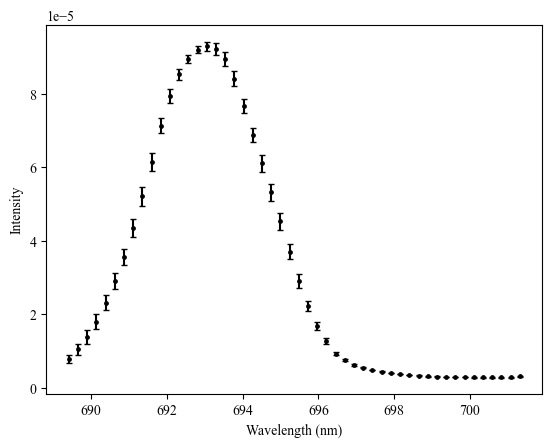

In [9]:
plt.figure(1)

plt.scatter(wavelengths, intensity_data, color = "black", s = 6)
plt.errorbar(wavelengths, intensity_data, yerr = intensity_errors, color = "black", linestyle = "None", capsize = 2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")

plt.show()

In [10]:
wavelengths = np.array(wavelengths)
wavelengths = wavelengths.flatten()
intensity_errors = np.array(intensity_errors)
intensity_data = np.array(intensity_data)


print("wavelengths:", wavelengths.shape)
print("intensity_data:", intensity_data.shape)
print("intensity_errors:", intensity_errors.shape)

wavelengths: (50,)
intensity_data: (50,)
intensity_errors: (50,)


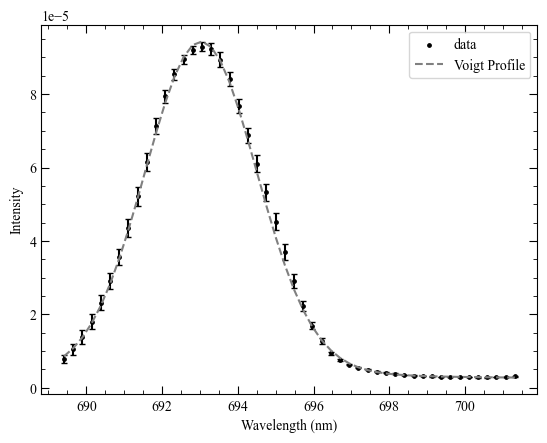

----- Fit Parameters -----
Centre: 693.027 ±  0.014nm
Theoretical R1: 694.3
Reduced Chi2 Voigt Profile: 1.2374844545893322


In [11]:
def voigt_model_single(x, amplitude, center, sigma, gamma, offset):
    return amplitude * voigt_profile(x-center, sigma, gamma) + offset

p0_single = [
    max(intensity_data) - min(intensity_data), #amplitude
    wavelengths[np.argmax(intensity_data)], #center
    1, #sigma
    1, #gamma
    min(intensity_data) # offset
]

bounds_single = (
    [0, min(wavelengths), 0, 0, -np.inf],   # lower
    [np.inf, max(wavelengths), np.inf, np.inf, np.inf]  # upper
)

popt_single, cov_single = curve_fit(
    voigt_model_single,
    xdata=wavelengths,
    ydata=intensity_data,
    sigma=intensity_errors,
    absolute_sigma=True,
    p0=p0_single,
    bounds=bounds_single
)

dof_voigt_single = len(intensity_data)-len(popt_single)
chi2_voigt_single = IE.chi2_function(voigt_model_single, popt_single, wavelengths, intensity_data, intensity_errors)
reduced_chi2_voigt_single = IE.rchi2_function(voigt_model_single, popt_single, wavelengths, intensity_data, intensity_errors,dof_voigt_single)

plt.figure(1)
plt.scatter(wavelengths, intensity_data, color = "black", s = 6, label = 'data')
plt.errorbar(wavelengths, intensity_data, yerr = intensity_errors, color = "black", linestyle = 'none', capsize = 2)
plt.plot(wavelengths, voigt_model_single(wavelengths, *popt_single), "--", color = "grey", label = 'Voigt Profile')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'major', direction = 'in', top = True, bottom = True, left = True, right = True, size = 6)
plt.tick_params(which = 'minor', direction = 'in', top = True, bottom = True, left = True, right = True, size = 3)

plt.show()

print(f"----- Fit Parameters -----")
print(f"Centre: {popt_single[1]:.3f} ±  {np.sqrt(cov_single[1][1]):.3f}nm")
print(f"Theoretical R1: 694.3")
print(f"Reduced Chi2 Voigt Profile: {reduced_chi2_voigt_single}")

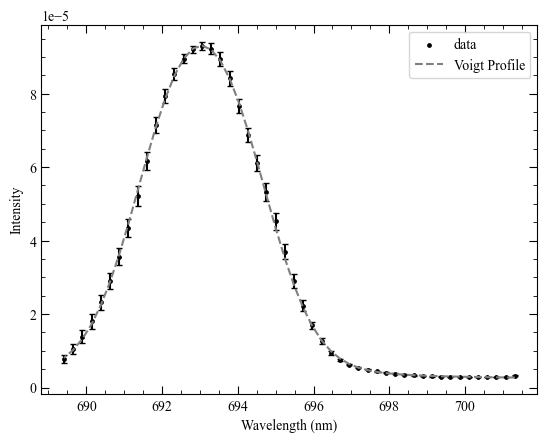

----- Fit Parameters -----
R1: 693.842 ±  0.066nm
Theoretical R1: 694.3
Amplitude frac R1: 0.4986
R2: 692.240 ±  0.050nm
Theoretical R2: 692.9
Amplitude frac R2: 0.5014
Reduced Chi2 Voigt Profile: 0.8691248623757116


In [12]:
def voigt_model_double(x, amplitude1, center1, sigma, gamma, amplitude2, center2, offset):
    return(amplitude1 * voigt_profile(x - center1, sigma, gamma)+
           amplitude2 * voigt_profile(x - center2, sigma, gamma)+
           offset)

center2_guess = wavelengths[np.argmax(intensity_data)]
center1_guess = center2_guess - 1.4

p0_double = [
    (max(intensity_data) - min(intensity_data))/2,  #amplitude1
    center1_guess,  #center1
    0.3,  #sigma1
    0.3,  #gamma1
    (max(intensity_data) - min(intensity_data))/2,  #amplitude2
    center2_guess,  #center2
    min(intensity_data)  # offset
]

bounds_double = (
    [0, #amplitude 1
     min(wavelengths), #center1
     0, #sigma
     0, #gamma
     0, #amplitude 2
     min(wavelengths), #center2
     -np.inf], #offset

    [np.inf, #amplitude 1
     max(wavelengths), #center1
     np.inf, #sigma
     np.inf, #gamma
     np.inf, #amplitude 2
     max(wavelengths), #center2
     np.inf] #offset
)


popt_double, cov_double = curve_fit(
    voigt_model_double,
    xdata=wavelengths,
    ydata=intensity_data,
    sigma=intensity_errors,
    absolute_sigma=True,
    p0=p0_double,
    bounds=bounds_double
)

dof_voigt_double = len(intensity_data) - len(popt_double)
chi2_voigt_double = IE.chi2_function(voigt_model_double, popt_double, wavelengths, intensity_data, intensity_errors)
reduced_chi2_voigt_double = IE.rchi2_function(voigt_model_double, popt_double, wavelengths, intensity_data, intensity_errors, dof_voigt_double)

plt.figure(1)
plt.scatter(wavelengths, intensity_data, color="black", s=6, label='data')
plt.errorbar(wavelengths, intensity_data, yerr=intensity_errors, color="black", linestyle='none', capsize=2)
plt.plot(wavelengths, voigt_model_double(wavelengths, *popt_double), "--", color="grey", label='Voigt Profile')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()

plt.minorticks_on()
plt.tick_params(which='major', direction='in', top=True, bottom=True, left=True, right=True, size=6)
plt.tick_params(which='minor', direction='in', top=True, bottom=True, left=True, right=True, size=3)

plt.show()

print(f"----- Fit Parameters -----")
print(f"R1: {popt_double[5]:.3f} ±  {np.sqrt(cov_double[5][5]):.3f}nm")
print(f"Theoretical R1: 694.3")
print(f"Amplitude frac R1: {popt_double[4]/(popt_double[0]+popt_double[4]):.4f}")
print(f"R2: {popt_double[1]:.3f} ±  {np.sqrt(cov_double[1][1]):.3f}nm")
print(f"Theoretical R2: 692.9")
print(f"Amplitude frac R2: {popt_double[0]/(popt_double[0]+popt_double[4]):.4f}")

print(f"Reduced Chi2 Voigt Profile: {reduced_chi2_voigt_double}")

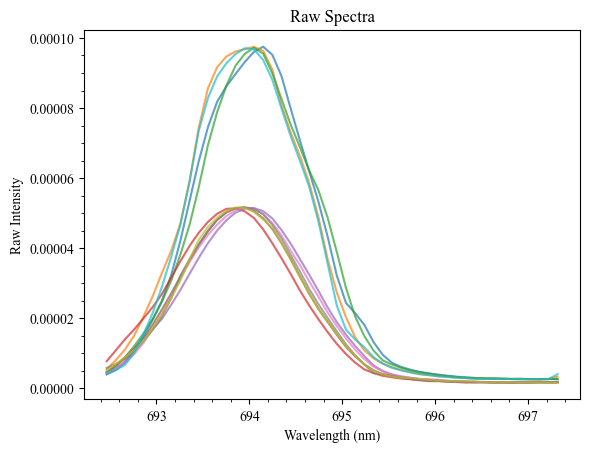

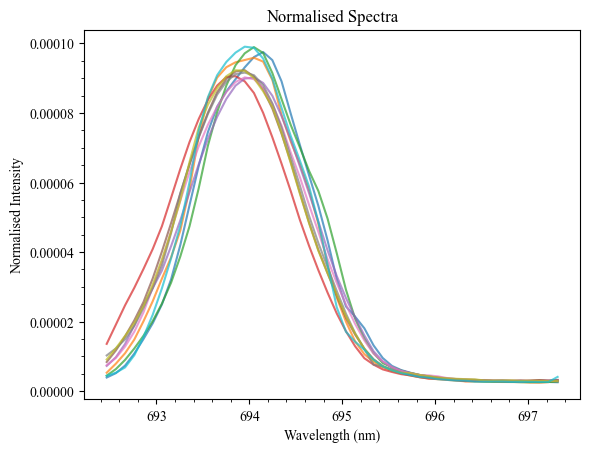

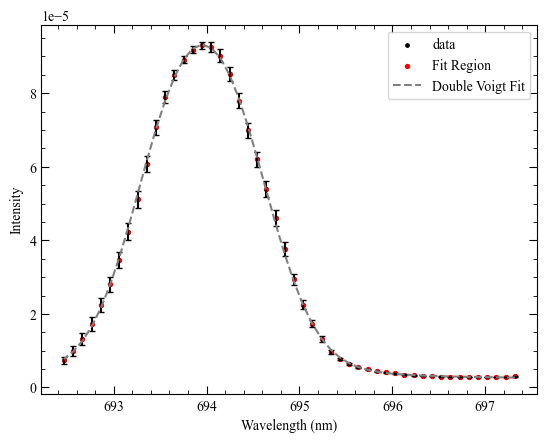


----- Fit Parameters -----
R1: 694.242 ± 0.165 nm
Theoretical R1: 694.3 nm
Amplitude frac R1: 0.5671

R2: 693.585 ± 0.163 nm
Theoretical R2: 692.9 nm
Amplitude frac R2: 0.4329

Reduced Chi²: 0.965


In [32]:
popt, cov, rchi2 = IE.analyse_ruby_spectrum(
    file= file,
    sheet_name= sheets[0],
    columns= cols[0],
    start_index=start_index,
    mask_fraction = 0.03
)


In [33]:
print(popt)

[6.48916353e-05 6.93585069e+02 4.35955673e-01 9.13514985e-02
 8.49981008e-05 6.56466821e-01 4.62686858e-01 2.27720022e-06]
